# Package Installation

In [1]:
!pip3 install torchmetrics tqdm --break-system-packages


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from glob import glob
from tqdm import tqdm
from torchmetrics import Accuracy

# Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Classes and Functions

In [4]:
def read_dataset(phase: str):
    df = pd.concat((pd.read_csv(f) for f in glob(f"./{phase.lower()}_data/*.csv")), axis=1)
    df_u = df.loc[:, ~df.columns.duplicated()].copy()

    return df_u

In [5]:
class Averaging():
    def __init__(self):
        self.sum = 0.
        self.counter = 0

    def cal_avg(self, val: float) -> float:
        self.sum += val
        self.counter += 1
        
        return self.sum / self.counter

    def reset(self) -> None:
        self.sum = 0.
        self.counter = 0

In [6]:
def train_one_epoch(model: nn.Linear, data_loader: DataLoader, optimizer: optim, loss_fn, avg_fn: Averaging, accuracy_fn, ep: int, device: str):
    model.train()

    avg_fn.reset()
    accuracy_fn.reset()

    with tqdm(data_loader, desc=f"Epoch: {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate average of loss
            loss_avg = avg_fn.cal_avg(loss.item())

            # Calculate accuracy
            accuracy_fn(yp, y_batch)
            accuracy = accuracy_fn.compute().item()

            trange.set_postfix(loss=loss_avg, accuracy=100*accuracy)

    return model, loss_avg, accuracy

In [7]:
def validation_one_epoch(model: nn.Linear, data_loader: DataLoader, loss_fn, avg_fn: Averaging, accuracy_fn, device: str):
    model.eval()

    avg_fn.reset()
    accuracy_fn.reset()

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Calculate average of loss
            loss_avg = avg_fn.cal_avg(loss.item())

            # Calculate accuracy
            accuracy_fn(yp, y_batch)
            accuracy = accuracy_fn.compute().item()

    return loss_avg, accuracy

In [8]:
def plot_loss_acc(train_loss: list, valid_loss: list, train_acc: list, valid_acc: list):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    axs[0].plot(train_loss, c='b', label="Train Loss")
    axs[0].plot(valid_loss, c='r', label="Valid Loss")
    axs[0].set_title("Learning Curve")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Cross Entropy Loss")
    axs[0].grid()
    axs[0].legend()
    
    axs[1].plot(train_acc, c='b', label="Train Acc")
    axs[1].plot(valid_acc, c='r', label="Valid Acc")
    axs[1].set_title("Accuracy Curve")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid()
    axs[1].legend()

# Read Train and Test Dataset

In [9]:
train_set = read_dataset("train")
test_set = read_dataset("test")

train_set.shape, test_set.shape

((369289, 37), (41033, 36))

# Select suitable Features and define Target

In [10]:
features_label = ["MEAN_RR","RMSSD","pNN25","pNN50","LF","HF","LF_HF"]
target_label = "condition"

# Train Phase

## Preprocessing

### Check Nan data

In [11]:
train_set[features_label].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369289 entries, 0 to 369288
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MEAN_RR  369289 non-null  float64
 1   RMSSD    369289 non-null  float64
 2   pNN25    369289 non-null  float64
 3   pNN50    369289 non-null  float64
 4   LF       369289 non-null  float64
 5   HF       369289 non-null  float64
 6   LF_HF    369289 non-null  float64
dtypes: float64(7)
memory usage: 19.7 MB


In [12]:
train_set[features_label].isna().sum()

MEAN_RR    0
RMSSD      0
pNN25      0
pNN50      0
LF         0
HF         0
LF_HF      0
dtype: int64

### Convert target object column

In [13]:
label_encoder = LabelEncoder()
train_set[target_label] = label_encoder.fit_transform(train_set[target_label])
train_set[target_label].unique()

array([1, 0, 2])

### Define X and y for Trainset

In [14]:
X = train_set[features_label].values.copy()
y = train_set[target_label].values

X.shape, y.shape

((369289, 7), (369289,))

### Convert to Tensor

In [15]:
x_train_tens = torch.FloatTensor(X)

y_train_tens = torch.LongTensor(y)

x_train_tens.shape, y_train_tens.shape

(torch.Size([369289, 7]), torch.Size([369289]))

### Standardization

In [16]:
x_train_mean = x_train_tens.mean(dim=0)
x_train_std = x_train_tens.std(dim=0)

x_train_mean.shape, x_train_std.shape

(torch.Size([7]), torch.Size([7]))

In [17]:
x_train_stand = (x_train_tens - x_train_mean) / x_train_std

x_train_stand.shape

torch.Size([369289, 7])

### Split Train and Validation sets

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_stand, y_train_tens, test_size=0.2, random_state=22)

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

(torch.Size([295431, 7]),
 torch.Size([73858, 7]),
 torch.Size([295431]),
 torch.Size([73858]))

### Make Data Loaders

In [19]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=3000, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=5000)

## Train Model

### Train

In [20]:
def train_model(num_epoch_ls: list[int], lr_ls: list[float]):
    if len(num_epoch_ls) != len(lr_ls):
        raise ValueError("The length of num_epoch_ls and lr_ls are NOT same!")

    in_features = x_train.shape[1]
    num_classes = len(y_train_tens.unique())
    
    h1 = 32
    h2 = 64
    h3 = 32
    
    model = nn.Sequential(
        nn.Linear(in_features, h1),
        nn.ReLU(),
        nn.Linear(h1, h2),
        nn.ReLU(),
        nn.Linear(h2, h3),
        nn.ReLU(),
        nn.Linear(h3, num_classes),
    ).to(device)
    
    train_loss_hist, valid_loss_hist = [], []
    train_acc_hist, valid_acc_hist = [], []
    
    acc_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    avg_fn = Averaging()
    
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch, lr in zip(num_epoch_ls, lr_ls):
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
        
        for ep in range(epoch):
            model, train_loss_val, train_acc_val = train_one_epoch(model, train_loader, optimizer, loss_fn, avg_fn, acc_fn, ep, device)
            valid_loss_val, valid_acc_val = validation_one_epoch(model, valid_loader, loss_fn, avg_fn, acc_fn, device)
        
            print(f"Valid accuracy: {100*valid_acc_val:.4}, loss: {valid_loss_val:.4}")
            
            train_loss_hist.append(train_loss_val)
            valid_loss_hist.append(valid_loss_val)
            
            train_acc_hist.append(train_acc_val)
            valid_acc_hist.append(valid_acc_val)

            # Add Eearly Stopping

    return model, train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist

In [21]:
model, train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist = train_model([10, 5, 5], [0.1, 0.05, 0.01])

Epoch: 0: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 23.39 batch/s, accuracy=60.2, loss=0.877]


Valid accuracy: 65.81, loss: 0.7791


Epoch: 1: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 22.34 batch/s, accuracy=69.3, loss=0.702]


Valid accuracy: 77.18, loss: 0.5795


Epoch: 2: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 21.71 batch/s, accuracy=75.9, loss=0.572]


Valid accuracy: 74.09, loss: 0.5572


Epoch: 3: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 20.34 batch/s, accuracy=80.2, loss=0.484]


Valid accuracy: 82.31, loss: 0.4244


Epoch: 4: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 21.43 batch/s, accuracy=84.1, loss=0.397]


Valid accuracy: 87.92, loss: 0.328


Epoch: 5: 100%|███████████████████████████████████| 99/99 [00:04<00:00, 22.14 batch/s, accuracy=87, loss=0.331]


Valid accuracy: 90.23, loss: 0.2666


Epoch: 6: 100%|███████████████████████████████████| 99/99 [00:04<00:00, 22.08 batch/s, accuracy=90, loss=0.262]


Valid accuracy: 91.28, loss: 0.2262


Epoch: 7: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 22.10 batch/s, accuracy=85.3, loss=0.406]


Valid accuracy: 89.57, loss: 0.2682


Epoch: 8: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 21.62 batch/s, accuracy=90.2, loss=0.254]


Valid accuracy: 92.05, loss: 0.2082


Epoch: 9: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 21.84 batch/s, accuracy=92.2, loss=0.204]


Valid accuracy: 90.52, loss: 0.2213


Epoch: 0: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 22.01 batch/s, accuracy=94.6, loss=0.145]


Valid accuracy: 94.83, loss: 0.139


Epoch: 1: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 22.15 batch/s, accuracy=95.3, loss=0.129]


Valid accuracy: 95.41, loss: 0.1256


Epoch: 2: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 22.60 batch/s, accuracy=95.7, loss=0.117]


Valid accuracy: 95.64, loss: 0.1179


Epoch: 3: 100%|███████████████████████████████████| 99/99 [00:04<00:00, 22.64 batch/s, accuracy=96, loss=0.109]


Valid accuracy: 96.1, loss: 0.1082


Epoch: 4: 100%|███████████████████████████████████| 99/99 [00:04<00:00, 21.93 batch/s, accuracy=96.4, loss=0.1]


Valid accuracy: 96.41, loss: 0.09845


Epoch: 0: 100%|████████████████████████████████| 99/99 [00:04<00:00, 21.19 batch/s, accuracy=96.8, loss=0.0907]


Valid accuracy: 96.82, loss: 0.09141


Epoch: 1: 100%|█████████████████████████████████| 99/99 [00:04<00:00, 20.54 batch/s, accuracy=96.9, loss=0.089]


Valid accuracy: 96.78, loss: 0.08988


Epoch: 2: 100%|████████████████████████████████| 99/99 [00:04<00:00, 21.89 batch/s, accuracy=96.9, loss=0.0874]


Valid accuracy: 96.91, loss: 0.08832


Epoch: 3: 100%|██████████████████████████████████| 99/99 [00:04<00:00, 21.75 batch/s, accuracy=97, loss=0.0859]


Valid accuracy: 96.88, loss: 0.08751


Epoch: 4: 100%|████████████████████████████████| 99/99 [00:04<00:00, 22.44 batch/s, accuracy=97.1, loss=0.0846]


Valid accuracy: 97.02, loss: 0.08547


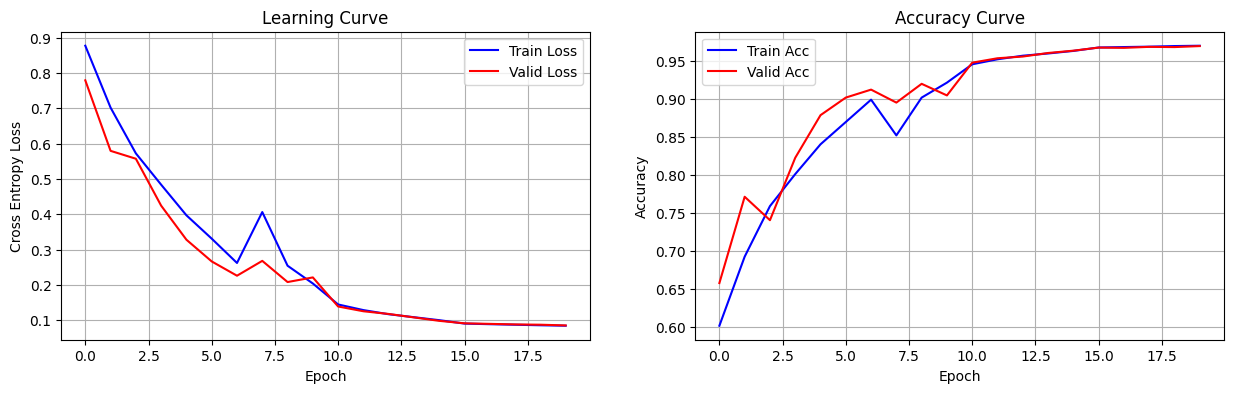

In [22]:
plot_loss_acc(train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist)

### Save final model

In [23]:
model.eval()
torch.save(model, "stress_level_detection_model.pt")

# Test Phase

## Load the model

In [24]:
final_model = torch.load("./stress_level_detection_model.pt", weights_only=False).to(device)

## Preprocessing Test_set

### Define X and y for test_set

In [25]:
x_test = test_set[features_label].values.copy()
y_test = test_set[target_label].values

x_test.shape, y_test.shape

((41033, 7), (41033,))

### Convert target object column

In [26]:
y_test_encoded = label_encoder.fit_transform(y_test)

### Convert to Tensor

In [27]:
x_test_ten = torch.FloatTensor(x_test)
y_test_ten = torch.LongTensor(y_test_encoded)

x_test_ten.shape, y_test_ten.shape

(torch.Size([41033, 7]), torch.Size([41033]))

### Standardization

In [28]:
x_test_stand = (x_test_ten - x_train_mean) / x_train_std

x_test_stand.shape

torch.Size([41033, 7])

### Testing

In [29]:
with torch.no_grad():
    x_test_device, y_test_device = x_test_stand.to(device), y_test_ten.to(device)
    
    yp = final_model(x_test_device)
    
    loss_fn = nn.CrossEntropyLoss()
    acc_fn = Accuracy(task="multiclass", num_classes=len(y_test_ten.unique())).to(device)
    
    test_loss = loss_fn(yp, y_test_device).item()
    acc_fn(yp, y_test_device)
    test_acc = acc_fn.compute().item()

# Testing Report

In [30]:
print(f"Test Accuracy: {100*test_acc:.4}, Cross Entropy Loss: {test_loss:.4}")

Test Accuracy: 96.94, Cross Entropy Loss: 0.08558
